# Prediction Focused Analysis With Canonical Functional Component Analysis: An Application To A Libyan Reservoir

Author: Lewis Li 

Date: May 6th 2016


## Introduction

In this notebook, we will demonstrate the application of Prediction Focused Analysis on an analog to Winstershall's Concession C97-I, which is located in the N-97 field in the Western Hameimat Trough of the Sirte basin of north-central Libya. The reservoir is thus comprised of 5 distinct compartments resulting in 4 uncertain fault transmissibilities. A large aquifer is located in the lowest compartment, but the depth of this oil water contact also remains uncertain. Other uncertain reservoir parameters are relative permeabilites for the oil and water phases and oil viscosity.

<img src="../../figures/FieldOverview.png" width="480">

We consider the situation where 5 producers and 3 injectors have already been drilled at the locations depicted in Figure 5. The field has been in production for 3500 days, and production data is available for all 5 wells. A decision needs to be made regarding the economic feasibility drilling of a 6th producer in the smallest reservoir compartment (denoted PNEW in Figure 5). Specifically, this decision will be made based on the forecasted performance of this new well over the next 4000 days. Therefore, we will seek to estimate the P10-P50-P90 forecasts of PNEW based on the first 10 years of production data from the existing 5 producers. 


## 2. Load Data

A prior set of models is required for CFCA to establish a statistical relationship between the data and forecast. In this case, a set of 500 prior models are generated by applying Monte Carlo. The prior models were forward modelled using a streamline simulator (3DSL) over all 7500 days, to encompass both the 3500 days of production data denoted by **d**, as well as the 4000 days of forecast **h** required to make the decision regarding the new well.


In [1]:
addpath('../cfca');
addpath('../util');
addpath('../../thirdparty/fda_matlab');
load('../../data/PriorRuns/Prior.mat');

We need to specify which data we will use as forecast, and which we will use as historical data.

In [2]:
% We call everything before this time step the 'observed' data (Corresponds to 3500 days)
HistoricalEnd = 65;

% We call everything after this step the 'forecast'
ForecastStart = 125;

% Total number of days simulated in 3DSL
TotalDaysSimulated=11500;

% Total number of time steps
TotalNumTimeSteps = 200;

% The column in the Data struct that refers to the attribute we want to use
% as the forecast/historical
ForecastColumn = 4;   % Oil Rate
HistoricalColumn = 4; % Oil Rate
TimeColumn = 2;       % Simulation Time

% Object on which forecasting is required (New well to be drilled)
ForecastObjectName = {'PNEW2'};

% Existing wells whose production rates are used as historical data
HistoricalObjectName = {'P1','P2','P3','P4','P5'};

% Generates data structure which will be used later for CFCA
[HistoricalStruct,ForecastStruct] = GenerateDataStructsWithInterpolation(Data,...
    PropertyNames,ForecastColumn,HistoricalColumn,TimeColumn,HistoricalEnd,...
    ForecastStart,TotalNumTimeSteps,[6 20],[6 20],ForecastObjectName,...
    HistoricalObjectName,TotalDaysSimulated);
    


For benchmarking, we will set one realization aside and use that as the truth. In this particular case, realization 150 was chosen as the reference. The production data from each of the 5 producers is shown below. The reference is shown in red $d_{obs}$, while the historical responses from the prior model are shown in gray ($d_{prior}$).

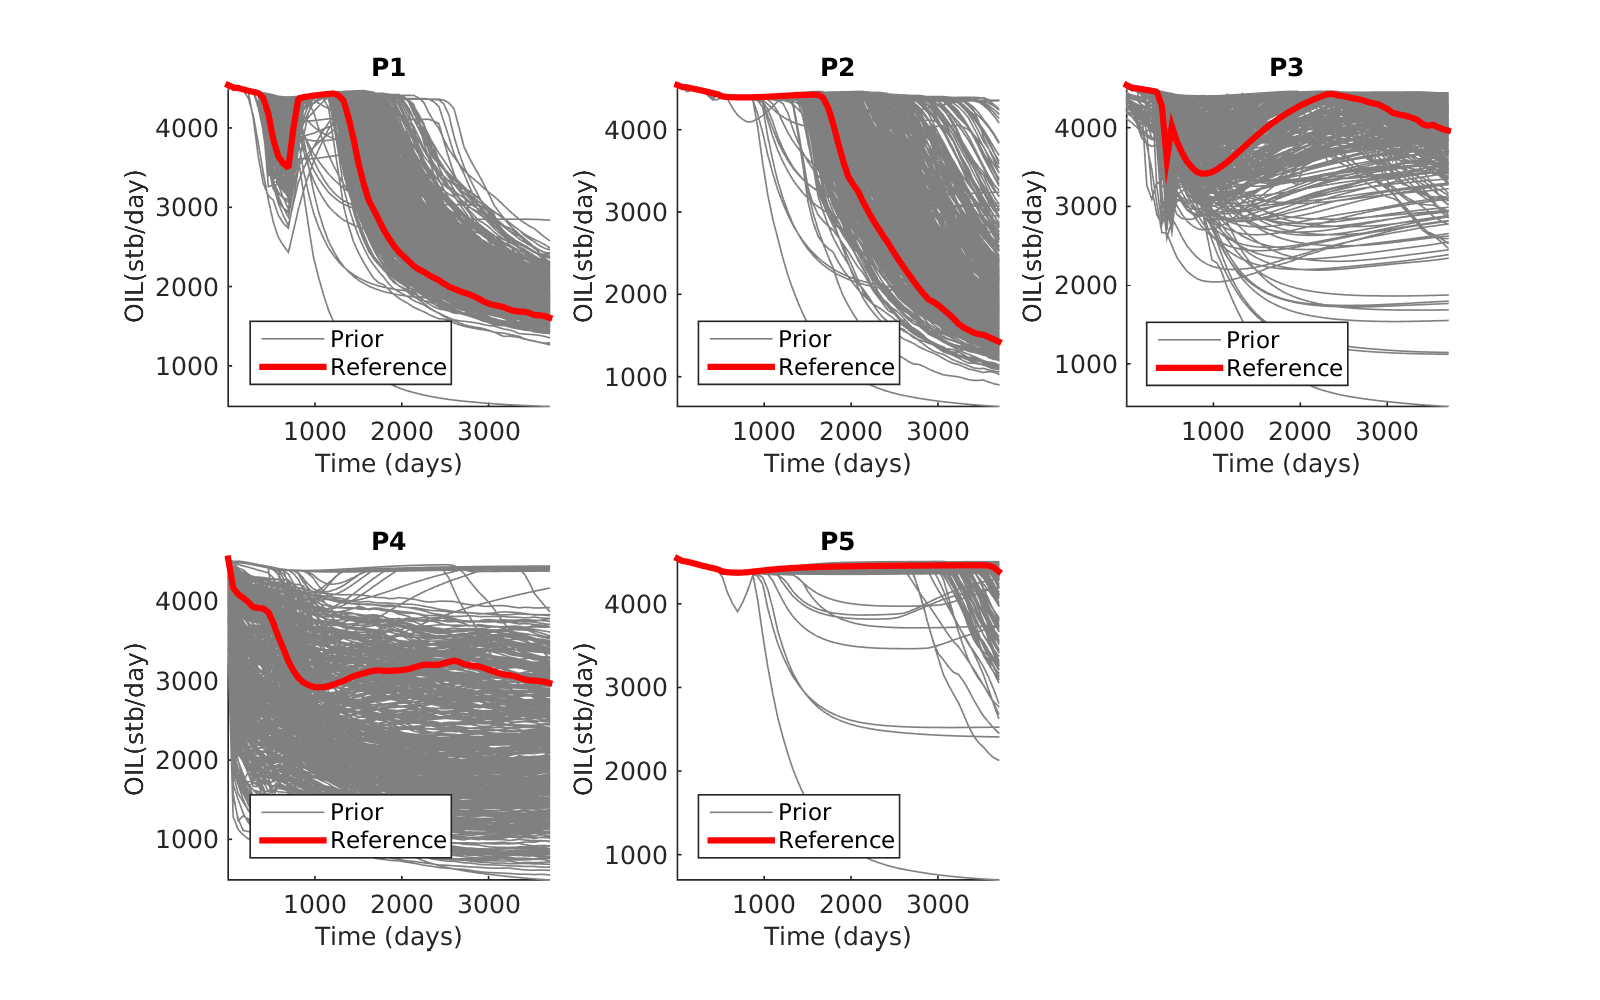

In [3]:
%plot inline -s 1600,1000

% Set aside one realization that we will deem the "reference";
TruthRealization = 12;

% Plot to verify
FontSize = 24;
PlotInputResponse( HistoricalStruct,TruthRealization,FontSize);


Likewise, we can plot the simulated forecast data for the well that is to be drilled for all the prior models $h_{prior}$. The reference (and unknown in reality) forecast is shown in red.

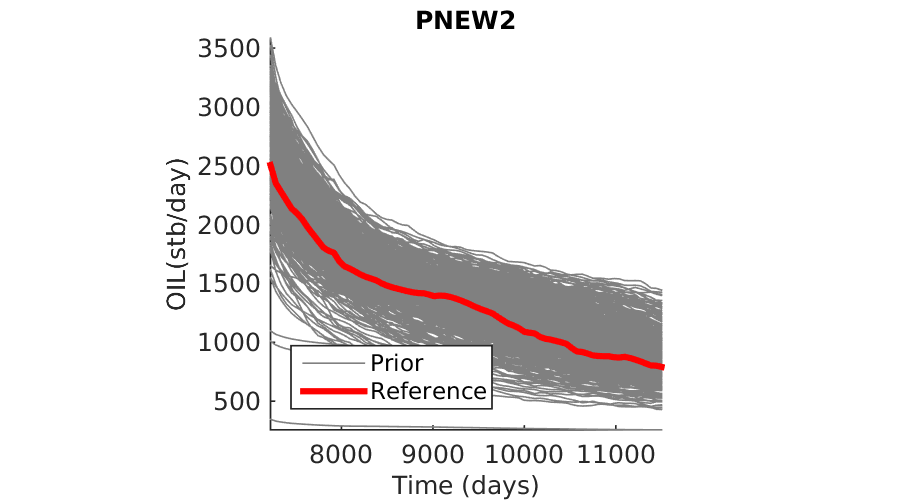

In [4]:
%plot inline -s 900,500
FontSize = 24;
PlotInputResponse( ForecastStruct,TruthRealization,FontSize);

## 3. Dimension Reduction With Functional Data Analysis

Each of the response time series are technically infinite dimension, but have been discretized to 200 time steps for purposes of flow simulation. We require a dimension reduction before we can build a statistical relationship between forecast and historical data. One method such method for dimension reduction is Functional Data Analysis (ref). The basic idea is to simply express each response as a linear combination of basis functions. 
$$d(t) = \sum_{i=1}^K \alpha_i B_{i,n}$$
We use B-splines as basis functions in this example. Using a spline-basis has the advantage of computational ease of evaluation as well as establishing derivatives. The number of knots and order is a modeling choice and will need to be tuned for each case, usually using cross-validation. In this example, we will use a 6th order spline with 20 knots to perform FDA. 

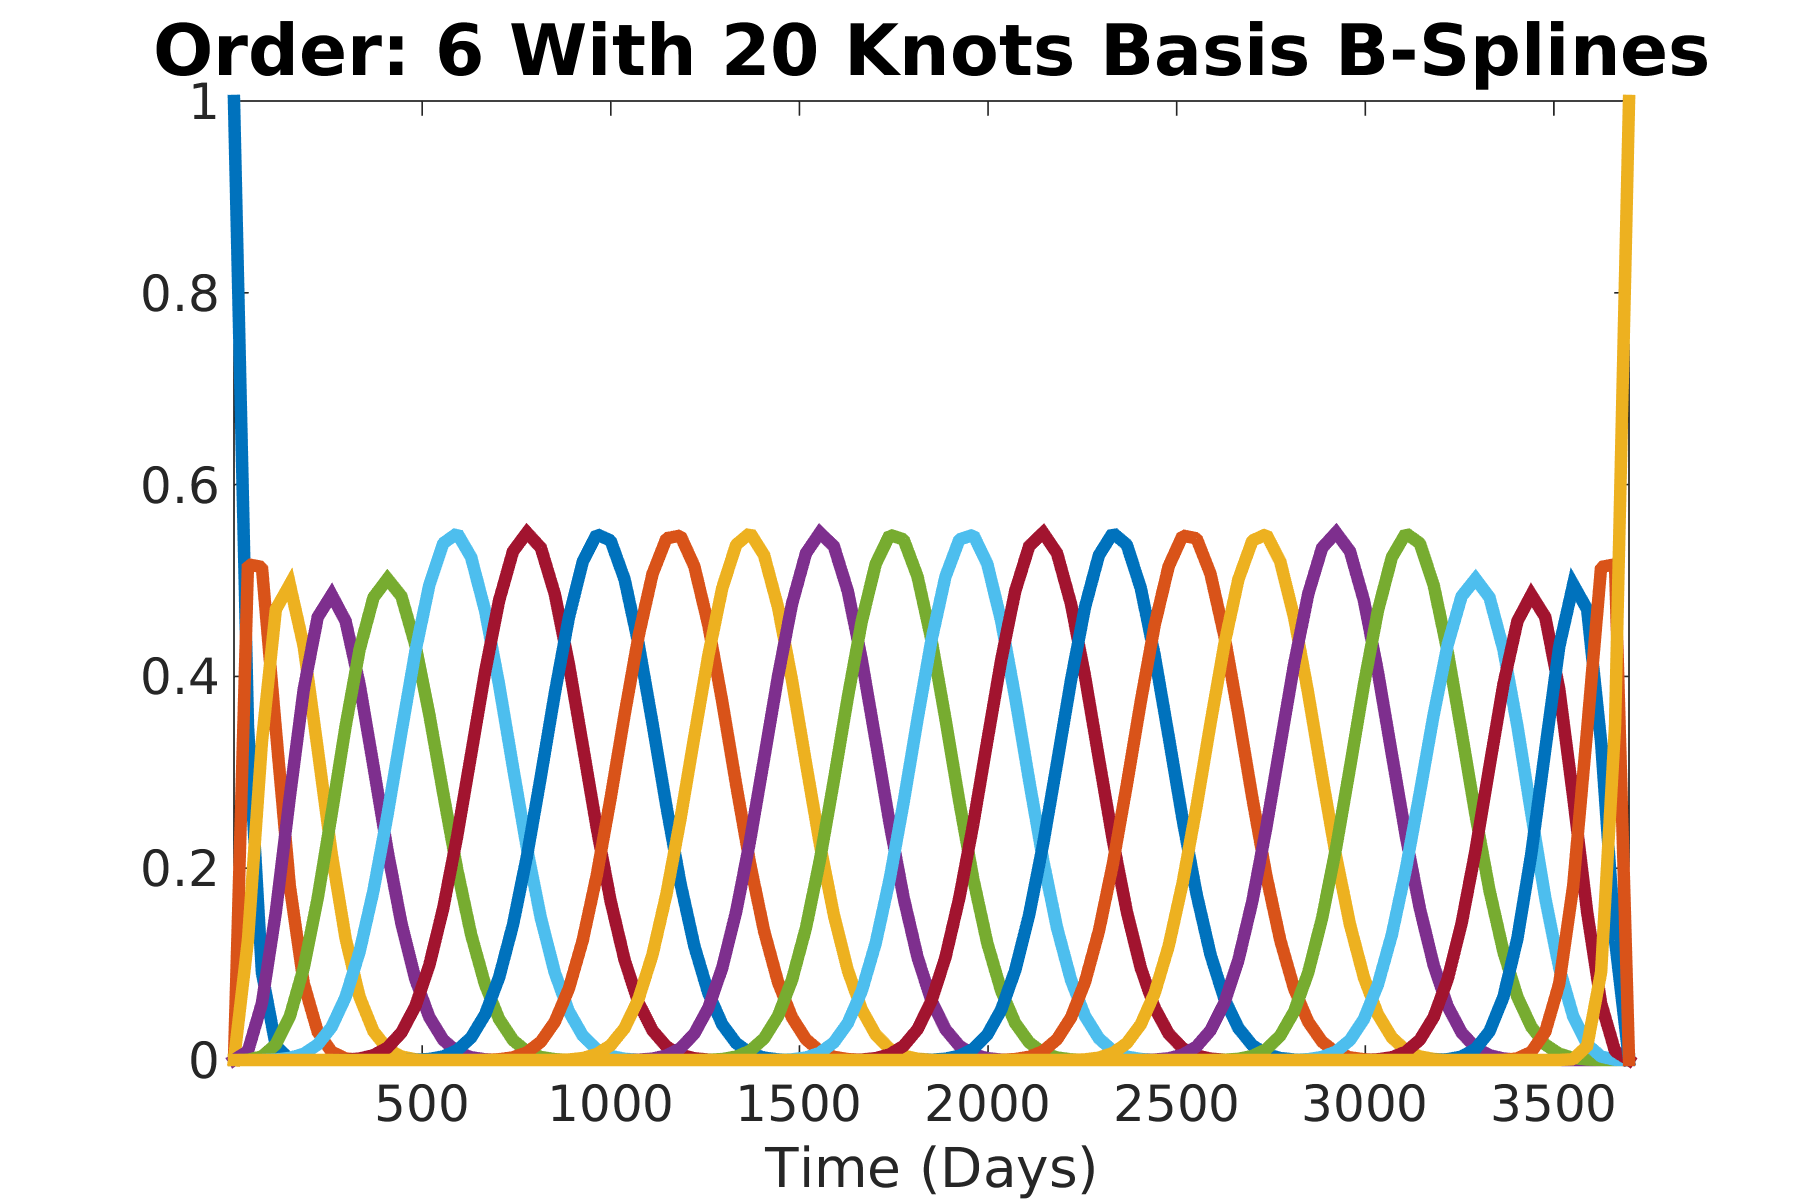

In [5]:
%plot inline -s 1800,1200
StartTime = min(HistoricalStruct.time);
EndTime = max(HistoricalStruct.time);
norder = HistoricalStruct.spline(1);
nknots = HistoricalStruct.spline(2);
nbasis = nknots+norder-2;

% Create a basis consisting of 6th order 20 knot B-spline
emptyBasis = create_bspline_basis([StartTime EndTime], nbasis, norder);

NumResponses = size(Data,3); predPCA = cell(NumResponses,1);

h = figure;
hBasis = plot(emptyBasis);
set(hBasis,'LineWidth',6);
title([ 'Order: ' num2str(norder) ' With ' ...
         num2str(nknots) ' Knots Basis B-Splines'],'FontSize',34)
xlabel('Time (Days)');
axis tight;
set(gcf,'color','w');
        
set(h, 'Units', 'normalized', 'Position', [0,0,0.75,0.75]);
set(gcf,'color','w');
set(gca,'FontSize',FontSize);

Solving for the $\alpha_i$ coefficients effectively reduces the dimension of each response curve to $K$. However, we can achieve further compression by applying Principal Component Analysis on the coefficients. This is termed Functional Princpal Component Analysis (FPCA). The effectiveness of the compression can be verified by inspecting the eigenvalues after PCA. In this case, we will look at the decomposition of Producer #1's historic oil production rate.

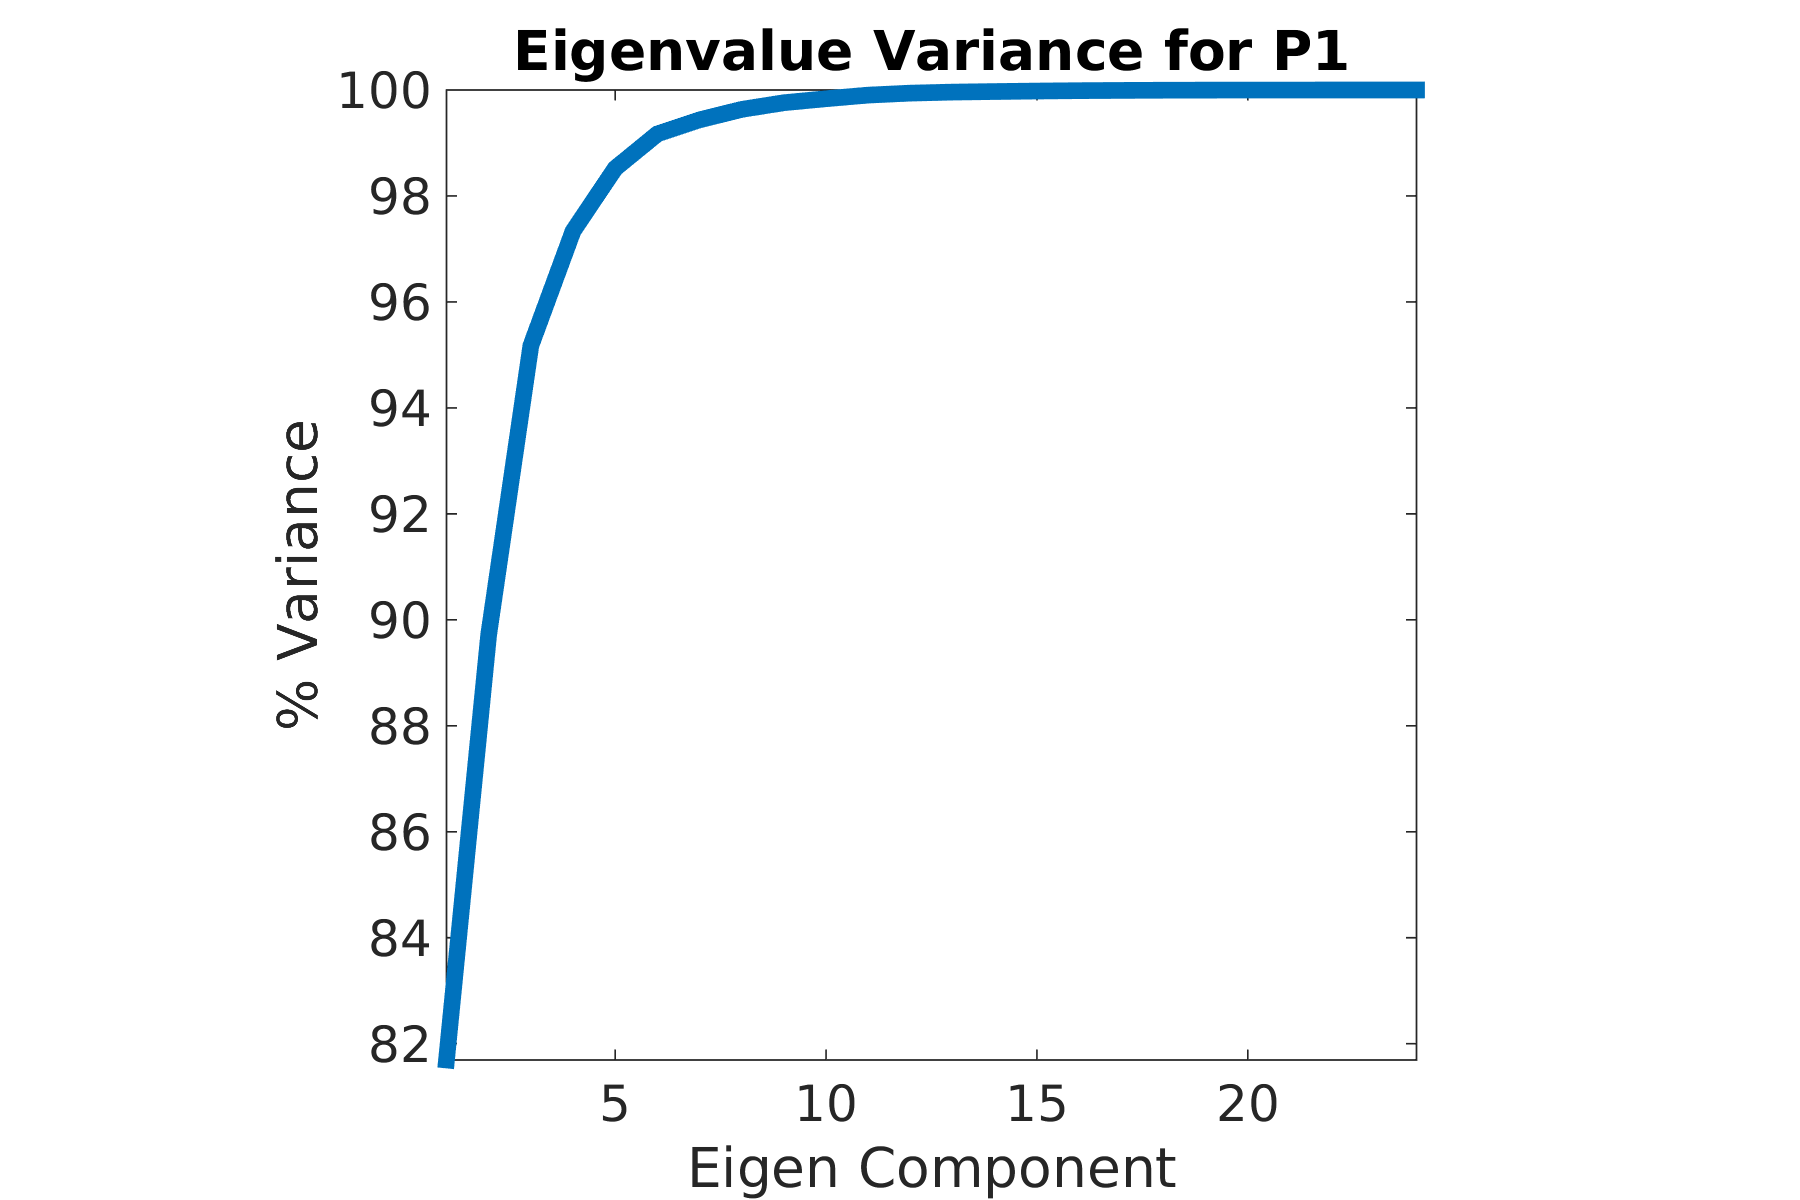

In [6]:
CurrentResponse = HistoricalStruct.data(:,:,1)';
    
predFd=data2fd(CurrentResponse,HistoricalStruct.time,emptyBasis,{'Time';'Model';HistoricalStruct.name});
predPCA{1} = pca_fd(predFd, nbasis);

%plot inline -s 1000,1000
hEigen=figure;
plot(cumsum(predPCA{1}.varprop)*100,'LineWidth',8); axis tight;
xlabel('Eigen Component'); ylabel('% Variance');
title(['Eigenvalue Variance for ' HistoricalStruct.ObjNames{1}]);
axis square; axis tight; set(gca,'FontSize',FontSize); set(gcf,'color','w');
set(hEigen, 'Units', 'normalized', 'Position', [0,0,0.75,0.75]);

This shows that only the first 5 eigencomponents are required to capture over 98% of the variation in the response of all the prior models for Producer 1. The choice of spline is then iteratively adjusted to minimize the average RMS between the original. It is also important to ensure that oscillations caused by Runge’s phenomena do not occur over any of the models, when high order splines are used. We verify the effectiveness of the compression by reconstructing the original curves from the basis functions and coefficients.

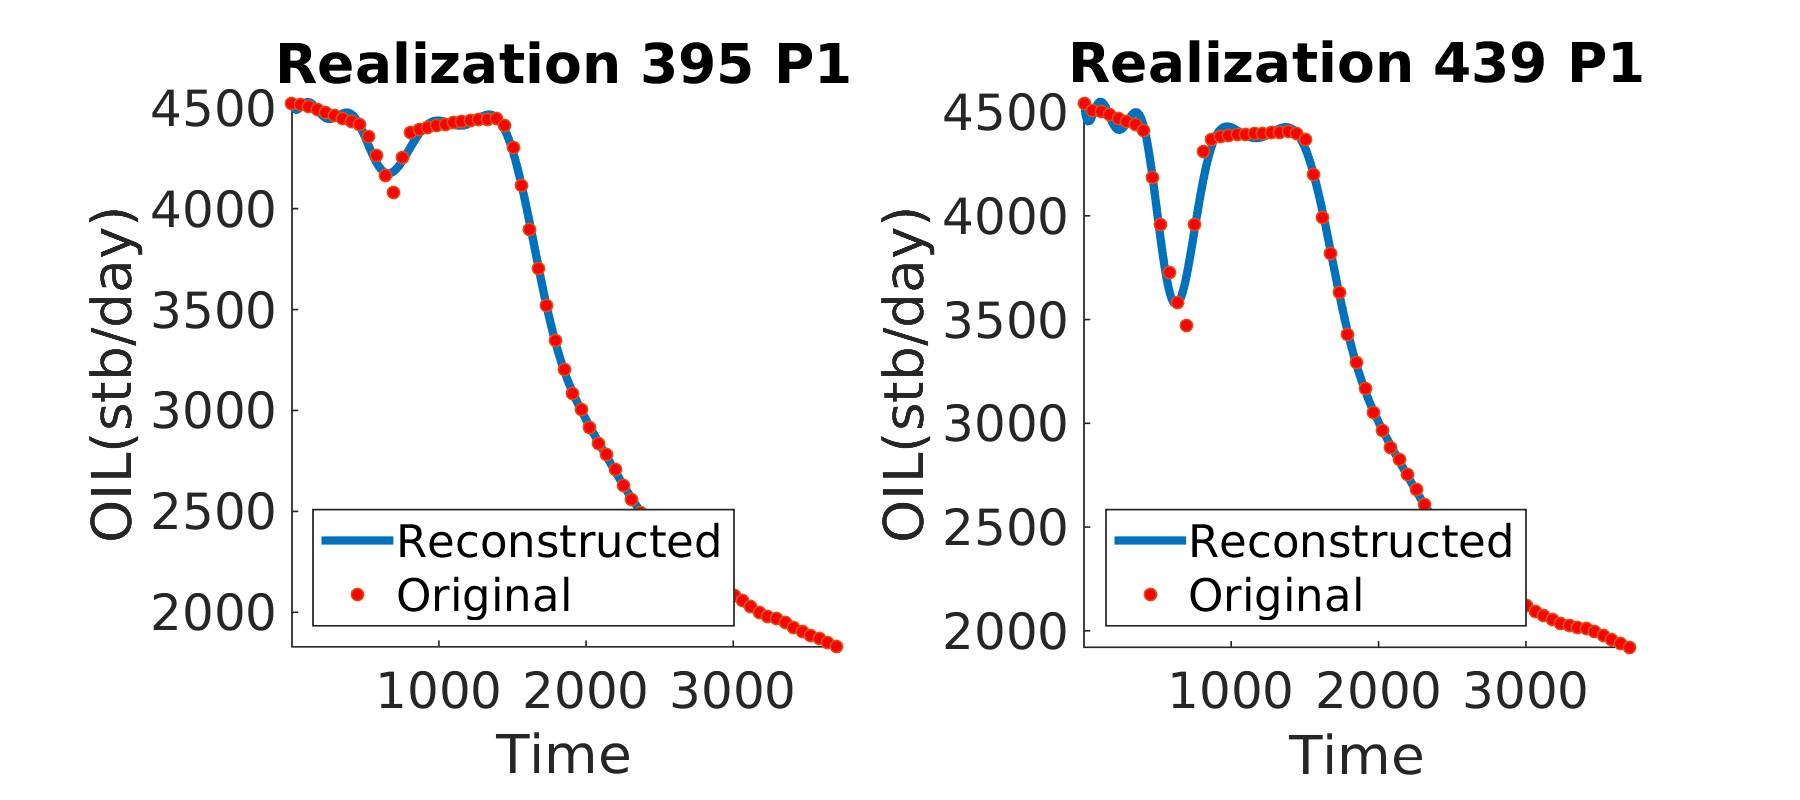

In [7]:
%plot inline -s 1800,800
% Plot two random fits
h2=figure;
i = randi([1 size(CurrentResponse,2)]);
subplot(1,2,1);
plotfit_fd(CurrentResponse(:,i),HistoricalStruct.time,predFd(i));
title(['Realization ' num2str(i) ' ' HistoricalStruct.ObjNames{1}]);
axis square; axis tight;
set(gca,'FontSize',FontSize);
       
i = randi([1 size(CurrentResponse,2)]);
subplot(1,2,2);
plotfit_fd(CurrentResponse(:,i),HistoricalStruct.time,predFd(i));
title(['Realization ' num2str(i) ' ' HistoricalStruct.ObjNames{1}]);
set(gcf,'color','w');
set(gca,'FontSize',FontSize);
axis square; axis tight;
set(h2, 'Units', 'normalized', 'Position', [0,0,0.75,0.75]);

Likewise, we can repeat this process for all producers, as well as the well that is to be drilled. We thus have low dimension reduction of all the required responses in the functional space $(d^f_{P1},d^f_{P2},...d^f_{P5})$ in addition to $h^f_{PNEW}$ We inspect the reconstruction of the forecasts 2 randomly selected models for the new well (PNEW).

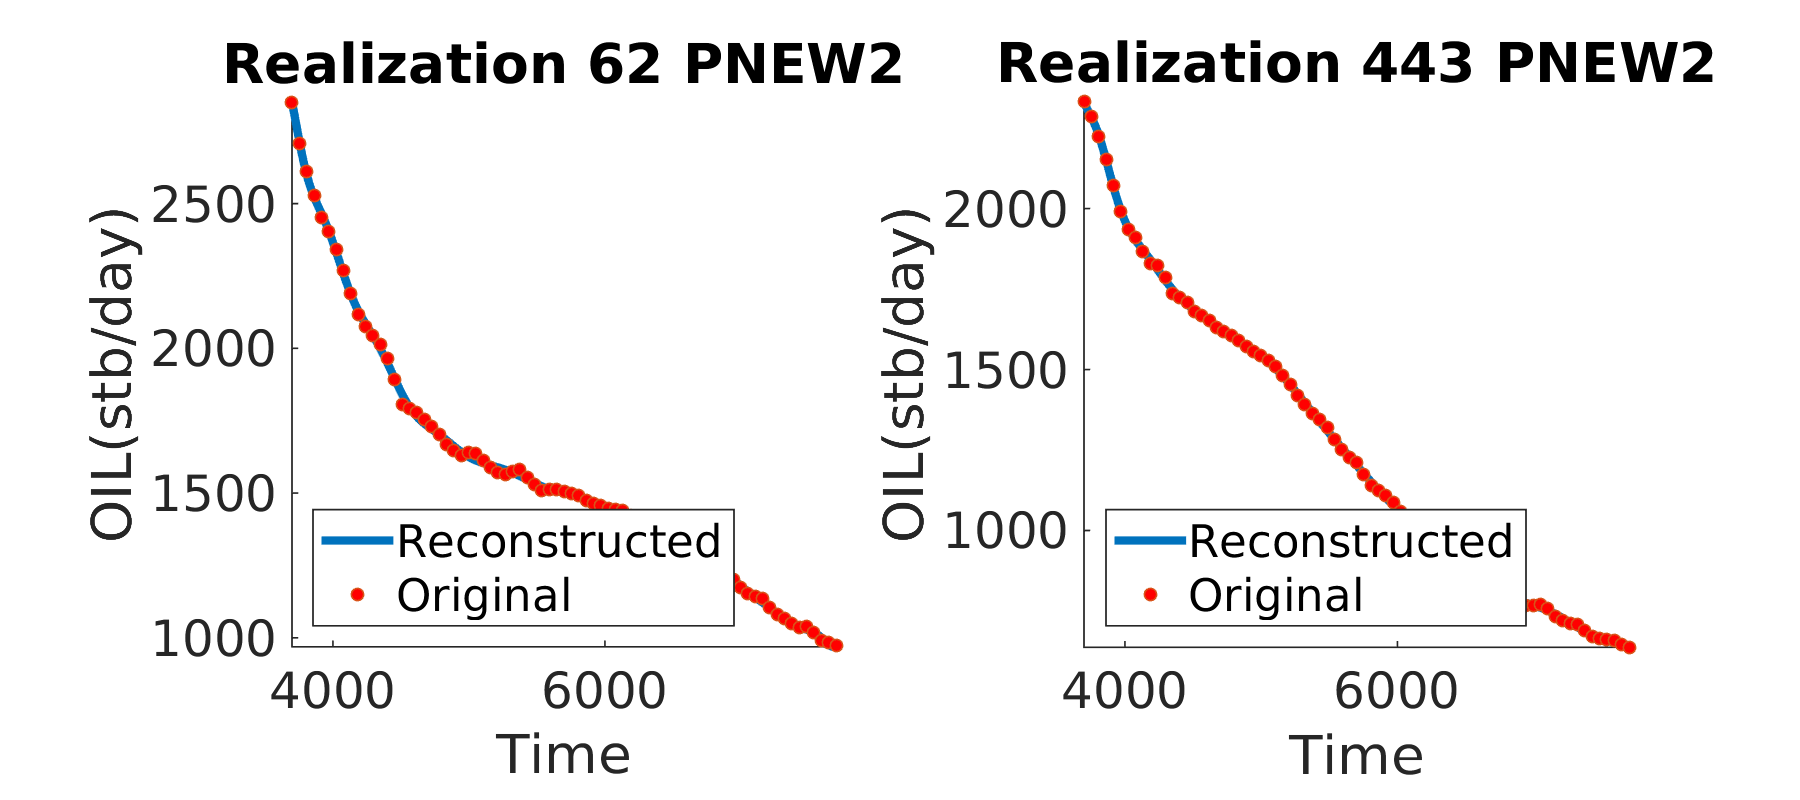

In [8]:
%plot inline -s 1800,800
warning('off','all');
histPCA = ComputeHarmonicScores(HistoricalStruct,0);

ForecastStruct.time = linspace(HistoricalStruct.time(end),...
    HistoricalStruct.time(end)+4000,length(ForecastStruct.time));
ForecastStruct.spline = [6 20];
predPCA = ComputeHarmonicScores(ForecastStruct,3);

We must then decide how many eigenvalues we should like to keep for constructing the statistical relationship. These two parameters are used to control a) the minimum number of eigenvalues required and b) the percentage of variation we would like to be kept.

In [9]:
MinEigenValues = 2;
EigenTolerance = 0.99;

## 4. Mixed PCA
We next keep only the eigenvalues that meet the specified conditions and generate a combined matrix of all the producers **(d<sup>f*</sup><sub>Producers</sub>)** and **(h<sup>f*</sup><sub>PNEW</sub>)**

In [10]:

Responses_Historical = HistoricalStruct.data;
NumHistoricalResponses = size(Responses_Historical,3);

AvailableRealizations = setdiff(1:size(Responses_Historical,1),...
    TruthRealization);

% Get number of required harmonics required for forecasts
nHarmPred = GetNumHarmonics(predPCA{1}, MinEigenValues,EigenTolerance);

% Get number of required harmonics required for forecasts
nHarmHist = 0;
for i = 1:NumHistoricalResponses
    responseNumHarms = GetNumHarmonics(histPCA{i},...
        MinEigenValues,EigenTolerance);
    nHarmHist = max(nHarmHist,responseNumHarms);
end

% Generate matrix of forecast harmonic scores
harmscrpred=predPCA{1}.harmscr;
Hf = harmscrpred(AvailableRealizations,1:nHarmPred);

% Generate matrix of historical harmonic scores
Df = zeros(length(AvailableRealizations),nHarmHist*NumHistoricalResponses);
dobs_f = zeros(1,nHarmHist*NumHistoricalResponses);

% Iterate over each historical response (ex: P1, P2)
for i = 1:NumHistoricalResponses
    harmscrhist=histPCA{i}.harmscr;
    
    % Need to re-arrange harmonic scores into Df such that the first
    % eigenvalues are placed in first
    for j = 1:nHarmHist
        Df(:,(i-1)*nHarmHist + j) = harmscrhist(AvailableRealizations,j);
        dobs_f(:,(i-1)*nHarmHist + j) = harmscrhist(TruthRealization,j);
    end
end



Since the production data is comprised of multiple wells, the relationship between each of the existing wells and the new well must be quantified. However, there exists a level of redundancy between the data from each production well. For instance, a shallower water oil contact in the aquifer would cause both P3 and P4 to experience water breakthrough earlier. Consequently, a second dimension reduction is applied to the production data in the form of a PCA on the matrix 

In [11]:
% Run PCA On Df
% Poor naming choice by FDA package... we need to remove it from the path
% in order to run PCA

%& Run this if we get an error about running the pca command.
rmpath('../../thirdparty/fda_matlab');

DfStar = [Df; dobs_f];
[~,score,~,~,explained,~]  = pca(DfStar);

% Variance explained
VarExplained = cumsum(explained);
NumEigAfterMPCA = sum((VarExplained<EigenTolerance*100));

display(['Need ' num2str(NumEigAfterMPCA) ' eigenvalues after Mixed-PCA to explain '...
num2str(EigenTolerance*100) ' percent of variation.'])

% Project dobs_f onto PCA basis
dobs_fpca = score(end,:);
score(end,:) = [];

% Perform CCA
Df = score;

Need 8 eigenvalues after Mixed-PCA to explain 99 percent of variation.


## 5. Maximizing the Linear Correlation Between Data and Forecast

So we have now effectively reduced our dimension from 5 producers and 200 element time series into 12 dimensions (8 from the producers **(d<sup>f*</sup><sub>MixedProducers</sub>)** and 4 from the forecast **(h<sup>f*</sup><sub>PNEW</sub>)**. This enables the possibility of performing regression between data and forecast. However, this is contingent on a sufficiently strong linear correlation between the variables, or else the resulting estimates from regression will be inconsistent. In this example, the correlation between first functional components of data and forecast is rather poor. This is usually attributed to the presence of cross-correlations among the functional data variables.

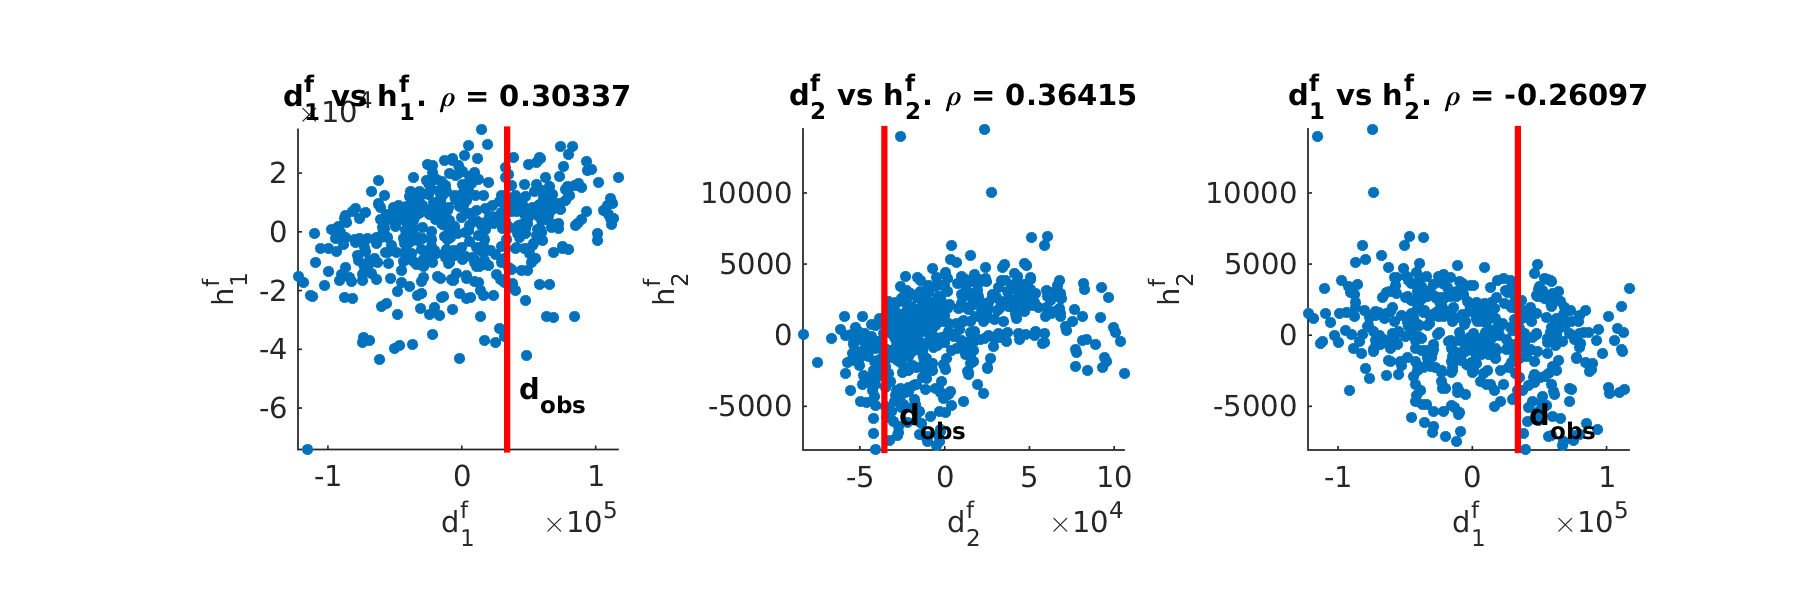

In [12]:
%plot inline -s 1800,600
FontSize=14;
PlotLowDimModels(Df,Hf,dobs_fpca,'f',FontSize);

To fully capitalize on the full multi-variate correlation between all component of h and all components of d a Canonical Correlation Analysis (CCA) is performed to transform the models into a canonical space. This is a form of partial least squares. CCA relies on a linear transformation of both  and  such that the components in such transformation are maximally correlated, or in terms of notation:
$$d^c = d^fA^T$$ and $$h^c = h^fN^T$$
where A and B are obtained as solution of:
$$max_{A,B} \frac{A\Sigma_{DH}B^T}{\sqrt{A\Sigma_{DD} A^T}\sqrt{B\Sigma_{HH} B^T}}$$ with
$$D = \begin{bmatrix}
    d_{1}^f  \\
    d_{2}^f  \\
    \vdots \\
    d_{N}^f 
\end{bmatrix}^T,
H = \begin{bmatrix}
    h_{1}^f  \\
    h_{2}^f  \\
    \vdots \\
    h_{N}^f 
\end{bmatrix}^T$$

The covariances are defined as:
$$\Sigma_{DH}=cov(D,H); \Sigma_{DD}=cov(D,D);\Sigma_{HH}=cov(H,H)$$

thereby maximizing the correlations between pairwise components of  $h^c_i$ and $d^c_i$ and  while constraining all the inter-component correlations between $d^c_i$ and $d^c_{i\neq j}$, between $h^c_i$ and $d^h_{i\neq j}$, $h^c_i$ and $d^h_{i\neq j}$ to be 0.


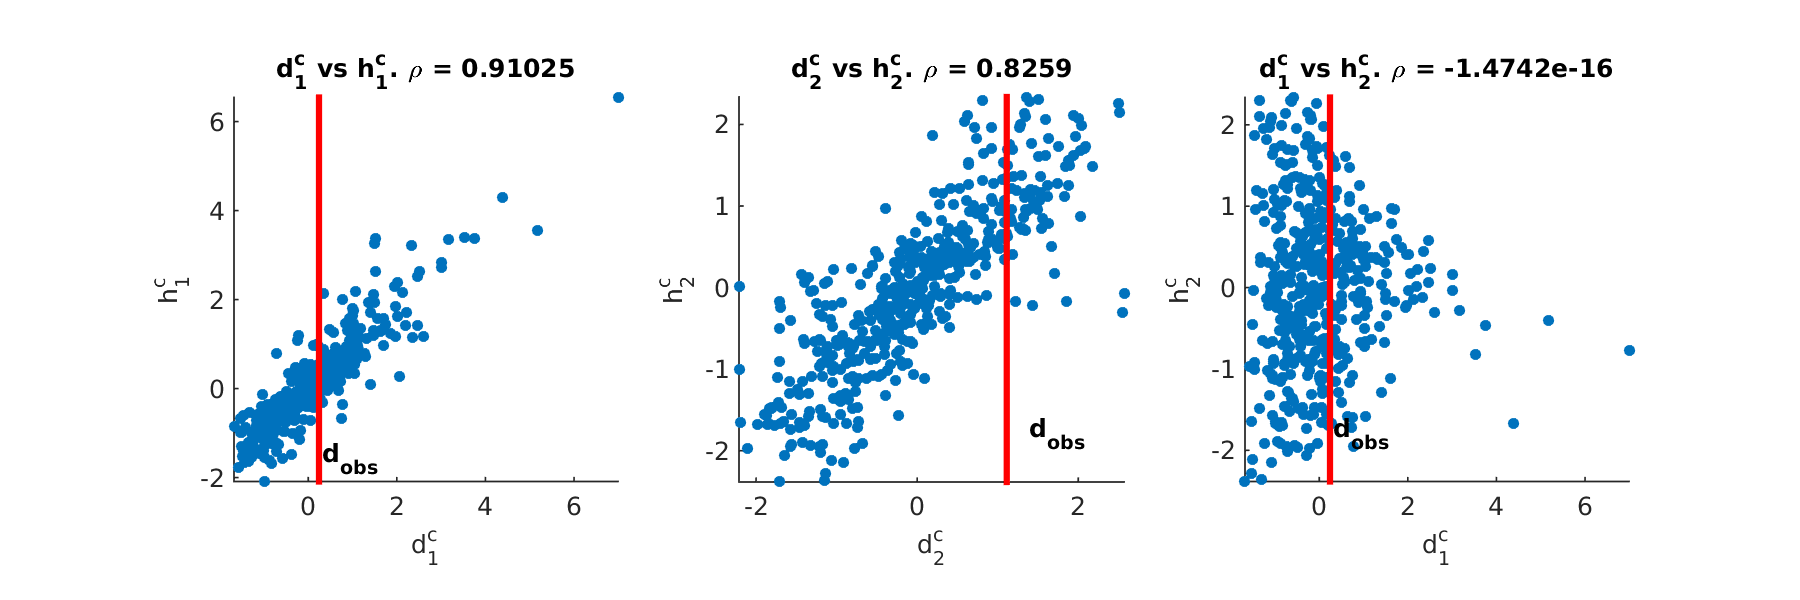

In [13]:
[A, B, ~, Dc,Hc] = canoncorr(score,Hf);

% Project dobs_f into canonical space
dobs_c=(dobs_fpca-mean(score))*A;

% Apply an outlier detection if required
%[Dc,Hc] = LSOutlierDetection(Dc,Hc,OutlierPercentile);

% Plot models in canonical space
PlotLowDimModels(Dc,Hc,dobs_c,'c',12);

 To apply linear Gaussian regression between $h_c$ and $d_c$, a normal score transform is required for $h_c$.

In [14]:
Hc_gauss = NormalScoreTransform(Hc,0);

# 6. Linear Gaussian Regression

The linear relationship between data and forecast implies we can express:
$$d^c =Gh^c$$
Likewise, a Gaussian likelihood model formulated as follows:
$$L(h^c) = exp(\frac{1}{2}(Gh^c-d^c_{obs})^TC^{-1}_{d^c} (Gh^c-d^c_{obs})$$
where $C^{-1}_{d^c}$ is the data covariance matrix of the canonical components. (Satija & Caers, 2015) derive a relationship between the stated covariance of the data variables. Since prior and likelihood are multi-variate Gaussian, the posterior is also Gaussian and the posterior mean and covariance can be readily estimated using classical methods (Tarantola, 2005). 

In [15]:
% Find best linear fit between Dc and Hc_gauss
G = Dc'/Hc_gauss';
DDiff= Dc'-G*Hc_gauss';
C_T = DDiff*DDiff'/length(Dc);


With likelihood and prior multi-variate Gaussian and a linear model, the posterior distribution $f(h^c|d_{obs})$ is also multivariate Gaussian with mean $\tilde{h^c}$ and covariance model  $\tilde{C^H}$

$$\tilde{h^c} = (G^TC_{d^c}^{-1}G + C_H^{-1})^{-1}(G^TC_{d^c}^{-1}d^c_{obs} + C_H^{-1}\bar{h^c})$$
$$\tilde{C^H} = (G^TC_{d^c}^{-1}G + C_H^{-1})^{-1}$$

In [16]:
C_H = cov(Hc_gauss);
H_CG_Mean = mean(Hc_gauss)';
 
mu_posterior = H_CG_Mean + C_H*G'*pinv(G*C_H*G' + C_T)*(dobs_c'-G*H_CG_Mean);
C_posterior = inv(G'*pinv(C_T)*G + inv(C_H));


### Note:
Steps 3 to 7 have been implemented in the ComputeCFCAPosterior.m function. We could just call that function.


In [17]:
%OutlierPercentile = 95; 
%[ mu_posterior, C_posterior, Dc, Df, Hc, Hf, B, dobs_c] = ComputeCFCAPosterior(...
%    HistoricalStruct, ForecastStruct, TruthRealization, EigenvalueTolerance,...
%    OutlierPercentile,1);

## 7. Sampling The Posterior
Gaussian regression thus produces a multi-variate normal posterior $f(h^c|d_{obs})$, that is easily sampled from to produce forecast components conditioned to $d^c_{obs}$. We can thus generate posterior by simply sampling from this multivariate Gaussian.

In [18]:
addpath('../../thirdparty/fda_matlab');
NumPosteriorSamples = 100;
PosteriorSamples = mvnrnd(mu_posterior',C_posterior,NumPosteriorSamples)';

We are not however, interested in posterior forecasts in the canonical space; rather we need to transform them back into the time-domain. We thus need to undo each of the transformations. We start by undoing the normal score transform. We can then observe the reduction in variane in the posterior models (red) versus prior (gray). This represents that a reduction in forecast uncertainty should be achieved.

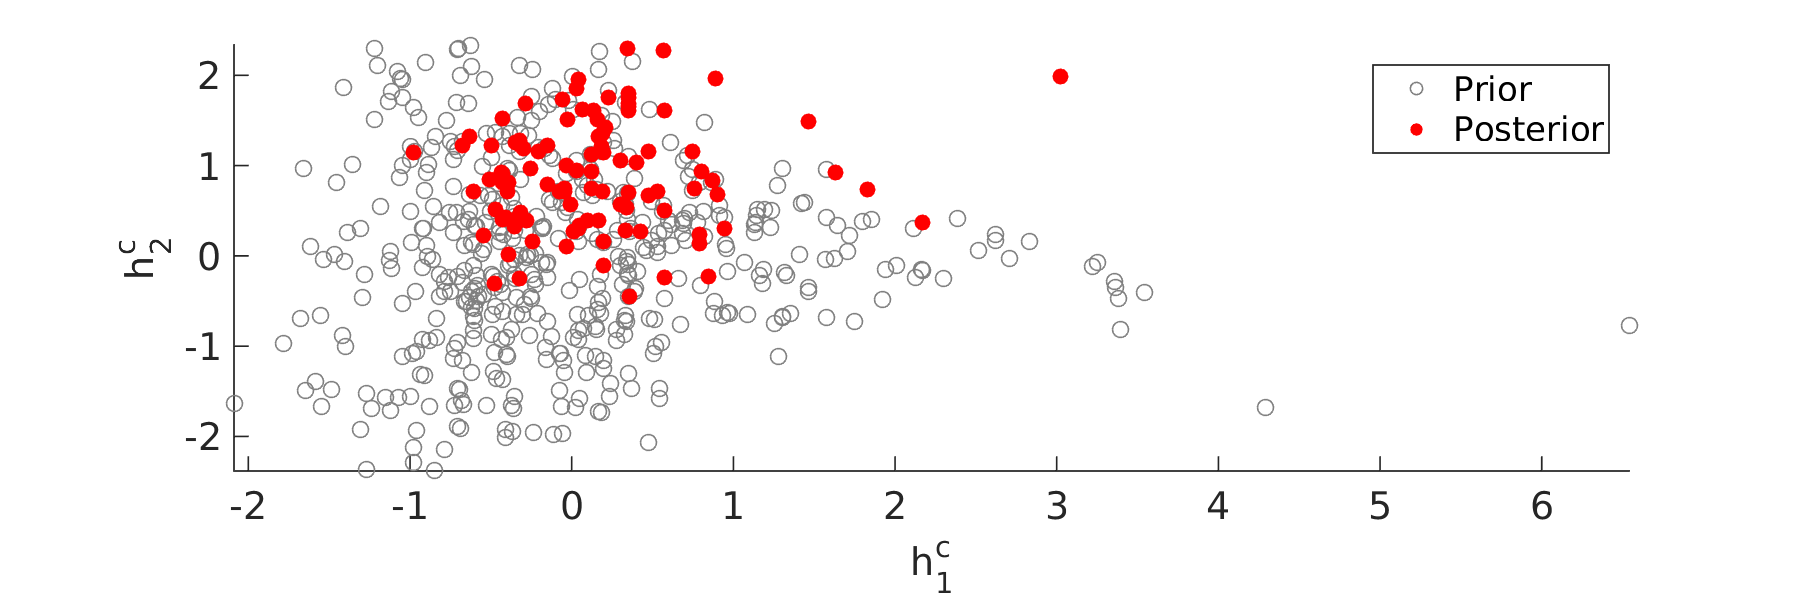

In [19]:
PosteriorSamplesTransformed = BackTransform(PosteriorSamples,Hc);

hold on;
FontSize=18;
h1=scatter(Hc(:,1),Hc(:,2),60,[0.5 0.5 0.5]);
h2=scatter(PosteriorSamplesTransformed(1,:),...
PosteriorSamplesTransformed(2,:),60,'r','filled');
hlegend = legend([h1(1),h2(1)],'Prior','Posterior');
ylabel('h^c_2','FontSize',FontSize); xlabel('h^c_1','FontSize',FontSize)
set(gca,'FontSize',FontSize); axis tight;

We next need to undo the canonical transform:
$$h^f_{posterior} = h^c_{posterior}B^{-1} + \overline{h^f_{prior}}$$

In [20]:
HpostCoef = PosteriorSamplesTransformed'*pinv(B)+repmat(mean(Hf,1)',...
        1,length(PosteriorSamplesTransformed))';

Finally, we need to reconstruct the time series, by undoing the FPCA and multiplying the coeffcients by the basis functions.

In [21]:
% Finally, we reconstruct the time series (mean_FDA + sum(HpostCoef*PhiH))
numPredCoeffs = size(Hf,2);
    
% Principal components for H
PhiH = eval_fd(ForecastStruct.time,predPCA{1}.harmfd);

% Re-construct time series
h_reconstructed = repmat(eval_fd(ForecastStruct.time,predPCA{1}.meanfd),...
        1,NumPosteriorSamples) + PhiH(:,1:numPredCoeffs)*HpostCoef(:,1:numPredCoeffs)';

### Note: 
Step 7 has been coded as a function with the following usage: 

In [22]:
%[h_reconstructed,Hf_post]= SampleCanonicalPosterior(...
%    mu_posterior,C_posterior,NumPosteriorSamples,Hc,B,Hf,...
%    ForecastStruct.time,predPCA);
%h_reconstructed =h_reconstructed';


We can now plot the posterior forecasts in the time doimain, as well as compute the updated P10,P50,P90. The posterior quantiles exhibit a significant reduction in uncertainty in comparison to the prior. 

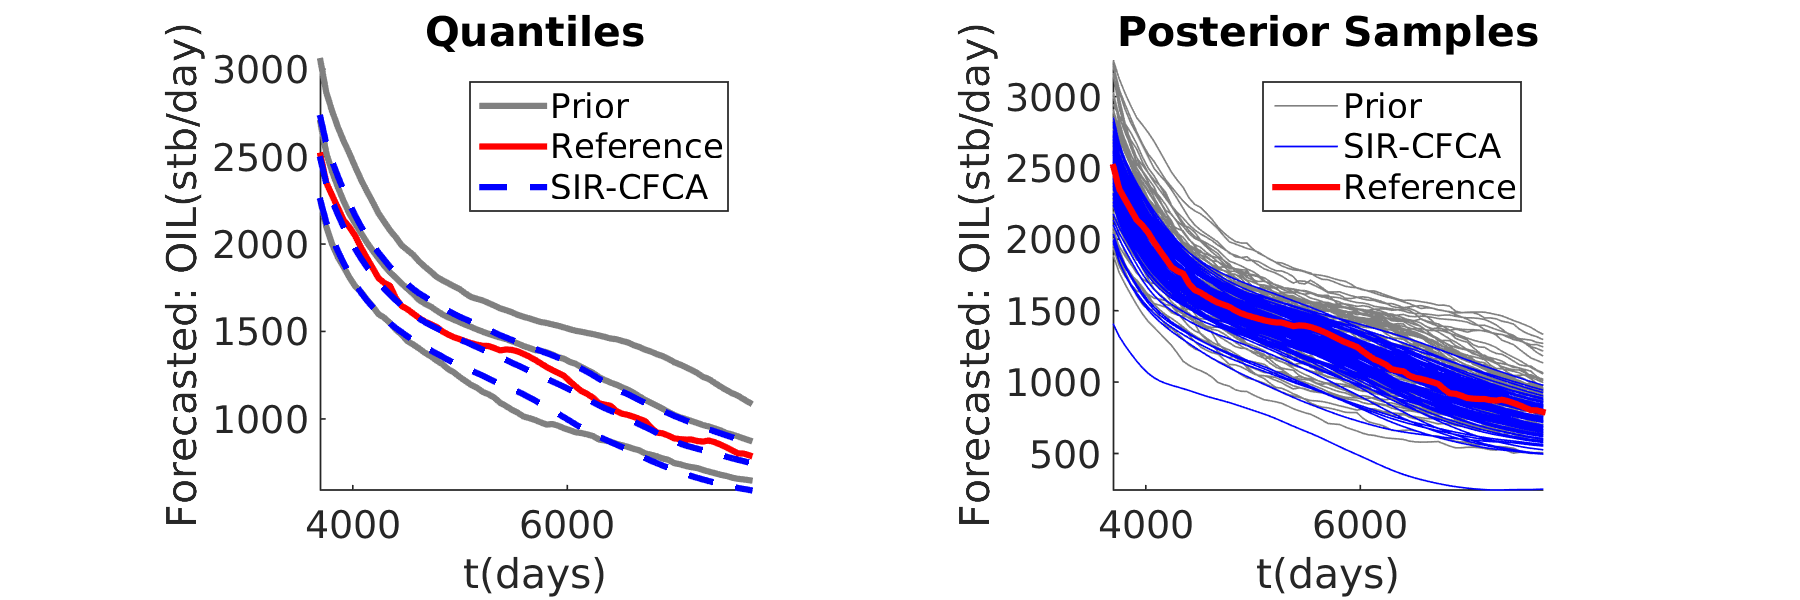

In [23]:
[PriorQuantiles, PosteriorQuantiles] = ComputeQuantiles(...
    ForecastStruct.data, h_reconstructed');

% Plot sampled responses and quantiles
PlotPosteriorSamplesAndQuantiles(ForecastStruct,TruthRealization, ...
    h_reconstructed',PriorQuantiles,PosteriorQuantiles);


## 8. Compare with Rejection Sampling
To compare the reduction in uncertainty provided by CFCA to an idealized case, where multiple history matched models are available, 5,000 realizations were sampled from the prior distribution, and forward simulated. Rejection sampling is performed on the resulting responses to identify the realizations that match the production data using the same methodology as (Satija & Caers, 2015), resulting in 127 history matched models, from which (only after history matching), a forecast is produced. Note that this is performed in the time domain rather than in functional canonical space.

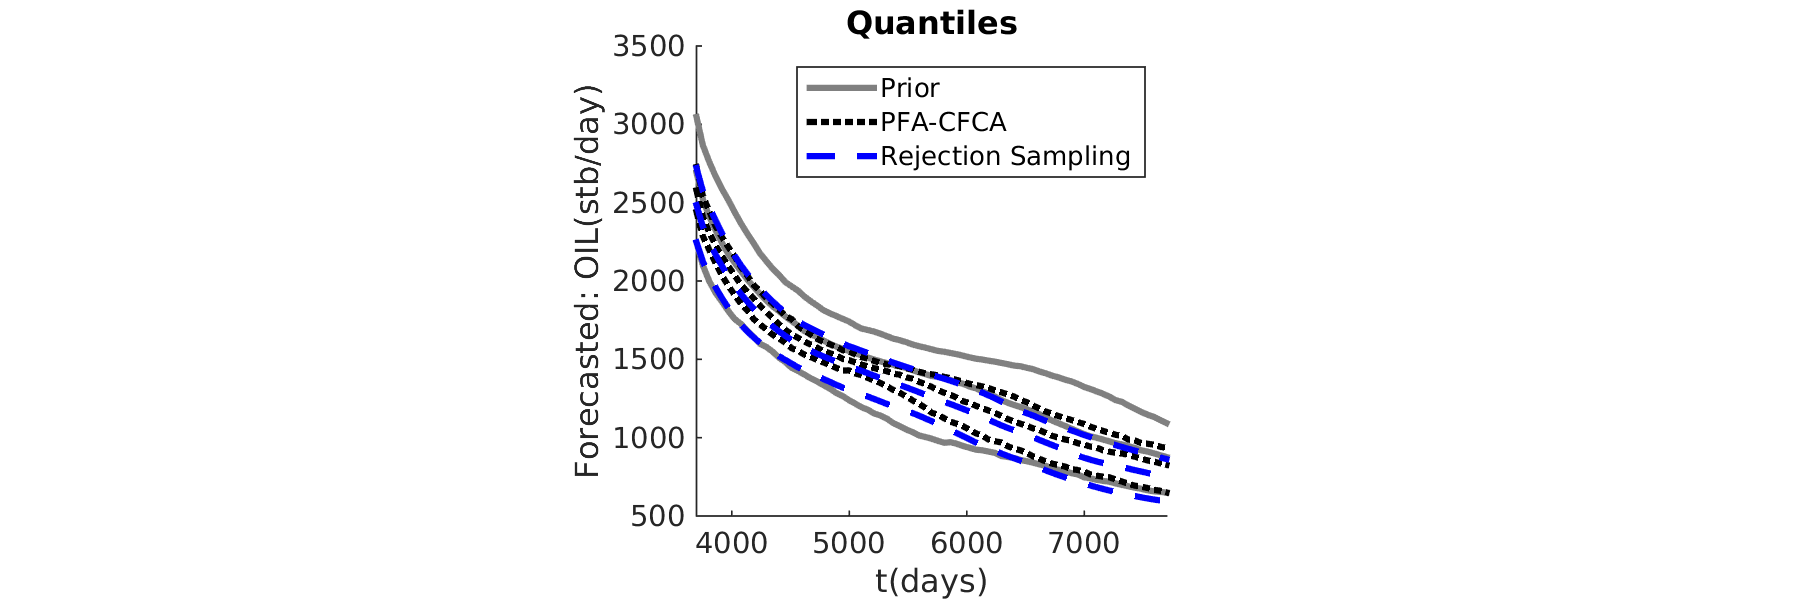

In [24]:
load('../../data/RejectionSampling/RJ.mat');
[PriorQuantiles, RJQuantiles] = ComputeQuantiles(ForecastStruct.data,RJStruct.data);

FontSize=14;

%plot inline -s 1200,1200
hold on;
h1 = plot(ForecastStruct.time,PriorQuantiles','color',[0.5 0.5 0.5],...
    'LineWidth',3);
h2 = plot(ForecastStruct.time,RJQuantiles,'k:','LineWidth',3);
h3 = plot(ForecastStruct.time,PosteriorQuantiles,'b--','LineWidth',3);
 
legend([h1(1), h2(1),h3(1)],'Prior','PFA-CFCA','Rejection Sampling');
xlabel('t(days)');ylabel(['Forecasted: ' ForecastStruct.name]);axis square;
title('Quantiles');
set(gca,'FontSize',FontSize);
xlim([round(ForecastStruct.time(1)) round(ForecastStruct.time(end)+1)])
set(gcf,'color','w');

## 9. How Informative Are Our Wells?
An uncertainty statement for a forecast, can be as simple as stating a posterior PDF of that forecast. Since all reservoir modeling forecasts are obtained from limited amount of samples from that PDF, a question of confidence on the stated uncertainty is required. For example, if an uncertainty interval based on quantiles is provided (often in terms of P10-P90), then the confidence on those quantiles needs to be calculated. First, this is relevant for testing whether the posterior quantiles are different from the prior quantiles, as this would indicate predictivity of the data towards that particular forecast. Note that uncertainty and confidence intervals need not be related. One may be very confident on a wide uncertainty, and less confident on a narrow uncertainty.  Since, this depends on a number of factors (the prior uncertainty, the particular data and forecast, the flow model, etc), a quantitative method is required to establish this relationship.

In this section we develop a hypothesis test, which tests whether the data informs the forecast (prediction variables h) using the above procedure. Based on the p-value of this hypothesis test, we then plot confidence vs uncertainty for several combinations of field data, to investigate what combination of historical data should be used for that forecast. It is clear that the most optimial situation occurs when we have small posterior uncertainty in combination with high confidence.

In general, the data  is informative when there is a significant difference between the prior distribution $f(h)$ and the posterior $f(h|d_{obs})$. Since both these pdfs are multivariate and functional, it would be difficult to develop a simple measure. As a proxy, we propose using the first functional component $h^f_1$  containing the maximum variability of H. We therefore define a theoretical difference between prior and posterior functional component as:

$$\delta=\Delta(f(h^f_1),f(h^f_1|d_{obs})$$

$\Delta$ can be any cdf or pdf based difference such as L1 norm difference (Fenwick et al., 2014), the
Kolmogorov-Smirnov difference ( (Justel, 1997); (Smirnov, 1948)), Jensen-Shannon or Kullback-Liebler divergence (Kullback & Leibler, 1951). 
For the purpose of hypothesis testing, the null hypothesis is that the prior and the posterior distributions of the first functional component are not different. For bootstrapping, B datasets are drawn from the existing N scoping runs without replacement, resulting in a B bootstrap estimates of the difference:

$$\hat{\hat{\delta_b}} = \Delta_{CDF}((\hat{\hat{F_b}}(h^f_1),\hat{\hat{F_b}}(h^f_1|d_{obs})), b = 1,...,N$$ 

The number of times $\hat{\hat{\delta_b}} < \hat{\delta}$ is a measure of how strong the predictivity is coinciding with the number of times the null-hypothesis is rejected. The more the null-hypothesis is rejected, the more confident we are on the informativeness of the data, hence a good measure is:

$$\omega = \frac{1}{B} \sum_{b=1}^B i(\hat{\hat{\delta_b}} < \hat{\delta})$$

where $i$ is the indicator function.


### Bootstrap Confidence When Using All Wells
We can apply the bootstrap test to the case where all 5 wells are used. The number of bootstraps should be set to be sufficiently large. This will take some time to run.


In [ ]:
%addpath('../bootstrap');
%addpath('../cfca');
%NumBootstrap = 500;
%BootstrapSize = 500;

%[omega, d_hat,d_empirical] = FunctionalBootstrap(...
%    HistoricalStruct, ForecastStruct, TruthRealization, EigenTolerance,...
%    NumBootstrap, BootstrapSize)


Depending on the number of bootstrap runs, we should obtain an omega between 0.65 and 0.75, which corresponds to a fairly high confidence in our posterior uncertainty reduction.

### Bootstrap Confidence Using Only P5
We next consider the case where only Producer 5 is used as the data for forecasting the new well. We first re-load the data such that only P5 is used.

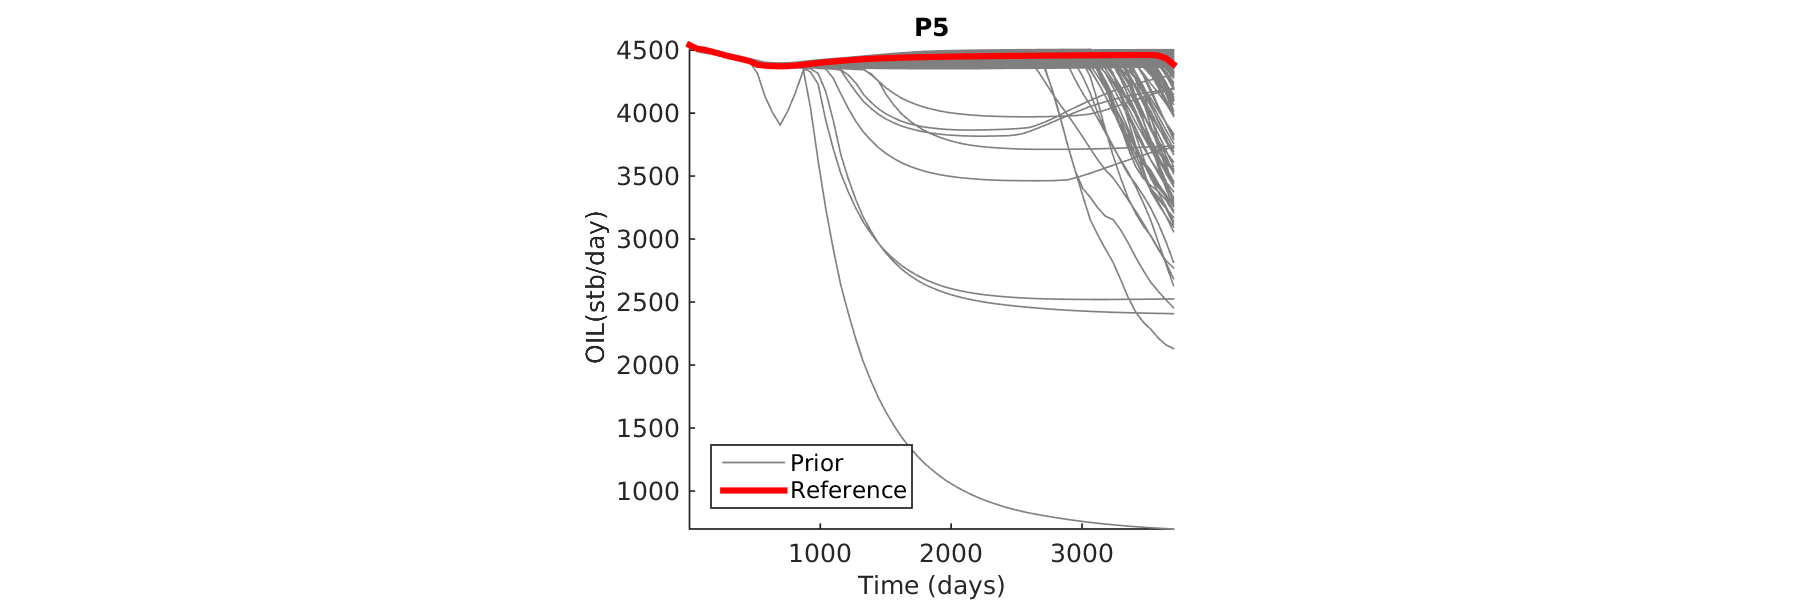

In [29]:
HistoricalObjectName = {'P5'};

% Generates data structure which will be used later for CFCA
[HistoricalStruct,ForecastStruct] = GenerateDataStructsWithInterpolation(Data,...
    PropertyNames,ForecastColumn,HistoricalColumn,TimeColumn,HistoricalEnd,...
    ForecastStart,TotalNumTimeSteps,[6 20],[6 20],ForecastObjectName,...
    HistoricalObjectName,TotalDaysSimulated);
ForecastStruct.time = linspace(HistoricalStruct.time(end),...
    HistoricalStruct.time(end)+4000,length(ForecastStruct.time));
h1  = PlotInputResponse( HistoricalStruct,TruthRealization);

From examining the prior models, we observe that most models have yet to experience water breakthrough, and thus have oil rates equal to the production limits. This means that we should not be able to extract much information about the forecast from this data; all models have the same data, but different forecasts.

In [ ]:
%plot inline -s 1800,600
PlotOn = 1;
FontSize = 14;
[ mu_posterior, C_posterior, Dc, Df, Hc, Hf, B, dobs_c] = ComputeCFCAPosterior(...
    HistoricalStruct, ForecastStruct, TruthRealization, 0.95,...
    100,PlotOn,FontSize);

In [27]:
[SampledPosteriorRealizations,Hf_post]= SampleCanonicalPosterior(...
    mu_posterior,C_posterior,NumPosteriorSamples,Hc,B,Hf,...
    ForecastStruct.time,predPCA);

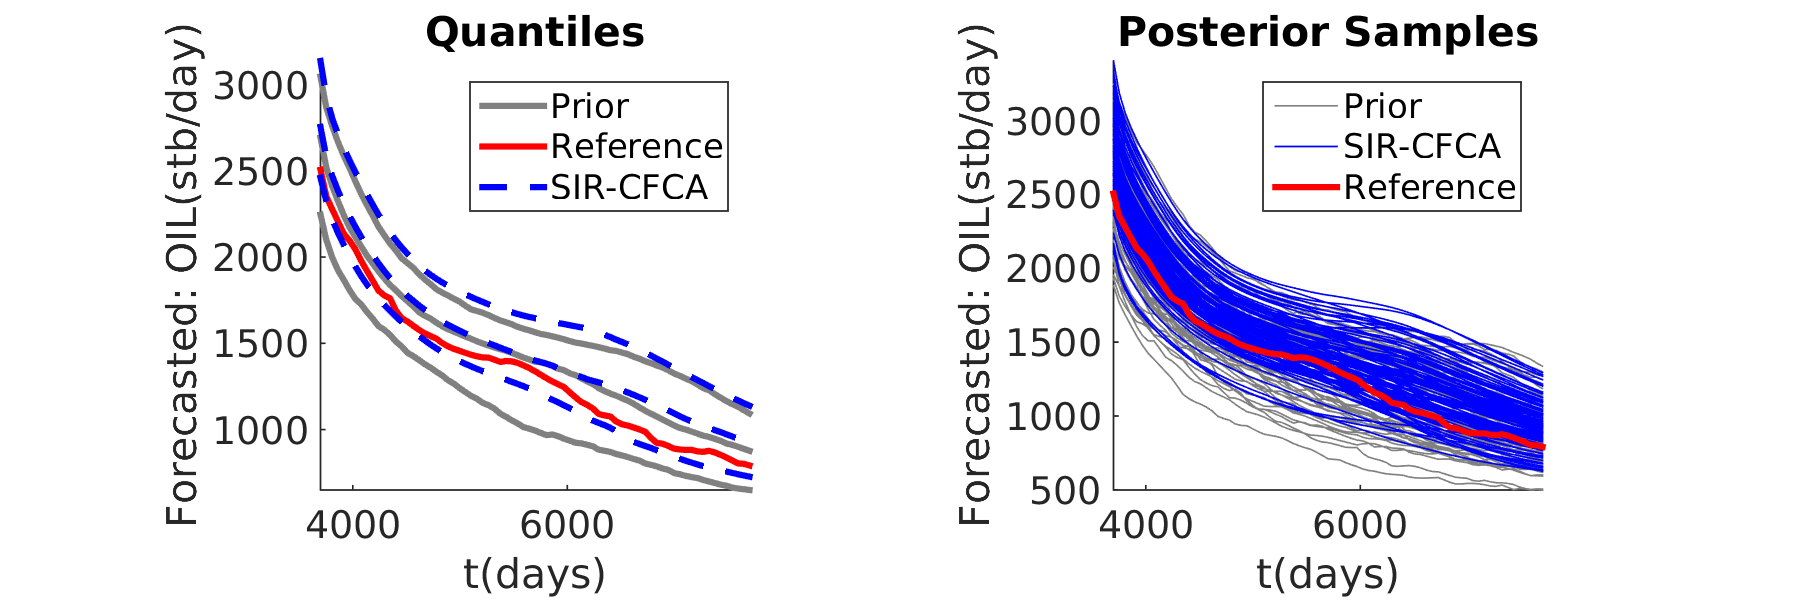

In [28]:
[PriorQuantiles, PosteriorQuantiles] = ComputeQuantiles(...
    ForecastStruct.data, SampledPosteriorRealizations);
    PlotPosteriorSamplesAndQuantiles(ForecastStruct,TruthRealization, ...
    SampledPosteriorRealizations,PriorQuantiles,PosteriorQuantiles);